In [1]:
# import custom functions from drakefunctions.py
from drakefunctions import *

In [3]:
# import modules

import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:_.0f}'.format)
from scipy.stats import poisson
from scipy.special import gamma  # not the one from scipy.stats
from math import factorial, exp, log
import datetime, time
from decimal import *

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

In [4]:
# CONSTANTS treated as variables for simulation

# inputs to the Drake equation
default_params = dict(
    # time step increments for calculations
    YEAR_STEPS = 1_000_000,
    # galactic attributes
    NUM_GALAXY = 100_000_000_000,  # number of stars in a galaxy
    GALAXY_RADIUS_LYR = 50_000,  # radius of the galaxy in lightyears
    MODERN_ERA = 10_000_000_000,  # years since 2nd gen stars, order of magnitude approx
    # pseudo-constants (treated as constants until Monte Carlo simulation)
    RS = 2, 
    FP = 1, 
    NE = 0.4, 
    FL = 1, 
    FI = 1, 
    FC = 0.1, 
    L = 1000,
    YEARS_PLANETS_TO_HABITABLE = 2_000_000_000, 
    YEARS_HABITABLE_TO_LIFE = 1_000_000_000, 
    YEARS_LIFE_TO_COMPLEX_LIFE = 1_000_000_000, 
    YEARS_COMPLEX_TO_INTELLIGENCE = 200_000_000, 
    YEARS_INTELLIGENCE_TO_CULTURE = 20_000_000, 
    YEARS_CULTURE_TO_TECH = 200_000, 
    EXTINCTION_SIMPLE = 5_000_000_000, 
    EXTINCTION_COMPLEX = 2_000_000_000, 
    EXTINCTION_INTELLIGENT = 200_000_000, 
    EXTINCTION_CULTURAL = 1_000_000, 
    # EXTINCTION_TECHNOLOGICAL = L,
    WEIBULL_SHAPE_PARAMETER = 0.4,  # k
    WEIBULL_SCALE_PARAMETER = 20_000  # lambda    
)

random_params = dict(
    # time step increments for calculations
    YEAR_STEPS = [1_000_000],
    # galactic attributes
    NUM_GALAXY = [100_000_000_000],  # number of stars in a galaxy
    GALAXY_RADIUS_LYR = [50_000],  # radius of the galaxy in lightyears
    MODERN_ERA = [10_000_000_000],  # years since 2nd gen stars, order of magnitude approx
    # pseudo-constants (treated as constants until Monte Carlo simulation)
    RS = [1, 2, 3],
    FP = [0.05, 0.2, 0.5, 1.0, 2.0],
    NE = [0.02, 0.1, 0.4, 1.0],
    FL = [0.01, 0.1, 1],
    FI = [0.01, 0.1, 1],
    FC = [0.01, 0.1, 1],
    L = [100, 1_000, 10_000, 100_000, 1_000_000],
    YEARS_PLANETS_TO_HABITABLE = [1_000_000_000, 2_000_000_000, 3_000_000_000], 
    YEARS_HABITABLE_TO_LIFE = [100_000_000, 1_000_000_000, 5_000_000_000], 
    YEARS_LIFE_TO_COMPLEX_LIFE = [100_000_000, 1_000_000_000, 5_000_000_000, 10_000_000_000], 
    YEARS_COMPLEX_TO_INTELLIGENCE = [100_000, 1_000_000, 50_000_000, 200_000_000, 1_000_000_000], 
    YEARS_INTELLIGENCE_TO_CULTURE = [10_000, 100_000, 2_000_000, 20_000_000, 200_000_000], 
    YEARS_CULTURE_TO_TECH = [1_000, 10_000, 100_000, 200_000, 2_000_000], 
    EXTINCTION_SIMPLE = [200_000_000, 1_000_000_000, 2_000_000_000, 5_000_000_000],  # these are mass extinction events
    EXTINCTION_COMPLEX = [200_000_000, 1_000_000_000, 2_000_000_000], # these are mass extinction events
    EXTINCTION_INTELLIGENT = [10_000, 100_000, 1_000_000, 10_000_000, 200_000_000, 1_000_000_000], 
    EXTINCTION_CULTURAL = [1_000, 10_000, 100_000, 1_000_000, 10_000_000], 
    # EXTINCTION_TECHNOLOGICAL = L,
    WEIBULL_SHAPE_PARAMETER = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # k
    WEIBULL_SCALE_PARAMETER = [100, 250, 500, 750, 1000, 5_000, 10_000, 20_000, 50_000, 100_000]  # lambda
)


In [7]:
# initialise params
params = params_set(default_params)

# THE TIME DEPENDENT DRAKE EQUATION

In [47]:
# THE ORIGINAL CALCULATION

# The Time Dependent Drake Equation
def TimeDependentDrake(params, output_year, P_tech_dominance=1.0, df_input="empty"):
    """
    output_year is the years since 2nd gen stars, 10B ~ now
    P_tech_dominance is the proportion of intelligent lifeforms that go extinct when technological life emerges
        P_tech_dominance = 1 assumes that only one intelligent lifeform can exist once a species gains technology
    outputs the number of instances of each category active during a time step (ie, over 1M years)
    NOTE: I would be surprised if df_input="empty" is not bad form, but I'm not sure how to do this...
    """
    
    # proportion of cultural civilizations that are consumed when tech life emerges
    P_tech_dominance = P_tech_dominance
    
    # columns used
    index = 'year'
    columns = ['year', 'num_stars', 'num_planets', 'num_habitable_planets', 'num_life', 
           'num_complex_life', 'num_intelligent_life', 'num_cultural_life', 'N', 'N_extinct']
    
    # if there is an input dataframe, use that, otherwise, initialise at year 0
    if type(df_input) == pd.DataFrame:
        # start over at the last row in the input DataFrame
        history_of_life = df_input.iloc[[-1]]
    else:
        # start at year 0 with no life and no 2nd gen stars
        history_of_life = pd.DataFrame(
            [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 
            columns = columns,
            index=[0]
        ).set_index(index)
    
    # initialise variables with input dict
    current_year = history_of_life.index[-1]
    num_stars = history_of_life.num_stars.iloc[-1]
    num_planets = history_of_life.num_planets.iloc[-1]
    num_habitable_planets = history_of_life.num_habitable_planets.iloc[-1]
    num_life = history_of_life.num_life.iloc[-1]
    num_complex_life = history_of_life.num_complex_life.iloc[-1]
    num_intelligent_life = history_of_life.num_intelligent_life.iloc[-1]
    num_cultural_life = history_of_life.num_cultural_life.iloc[-1]
    N = history_of_life.N.iloc[-1]
    N_extinct = history_of_life.N_extinct.iloc[-1]

    while current_year < output_year:
        
        # increment year
        current_year += params['YEAR_STEPS']
        num_new_stars = star_formation(params, current_year, num_stars)
        
        # functions - reverse order so that growth is based of previous generation
        
        # number of extinctions
        extinctions = new_extinctions(params, num_stars, num_life, num_complex_life, num_intelligent_life, num_cultural_life, N)
        num_life -= extinctions[0]
        num_complex_life -= extinctions[1]
        num_intelligent_life -= extinctions[2]
        num_cultural_life -= extinctions[3]
        N -= extinctions[4]
        N_extinct += extinctions[4]  # track technological extinctions
        
        # number of technological species
        new_tech_life = new_technological(params, num_cultural_life, N)
        N += new_tech_life
        
        # number of cultural civilizations
        num_cultural_life += transition(params, num_intelligent_life, num_cultural_life, params['YEARS_INTELLIGENCE_TO_CULTURE'])  
        # assumes only (1 - P_tech_dominance) cultural civilizations once one civilization gains tech
        # equivalent to neandrethal going extinct before we gain technology (probably because of us)
        num_cultural_life -= new_tech_life * P_tech_dominance
        
        # number of intelligent life
        num_intelligent_life += transition(params, num_complex_life, num_intelligent_life, params['YEARS_COMPLEX_TO_INTELLIGENCE'])
        
        # number of complex lifeforms
        num_complex_life += transition(params, num_life, num_complex_life, params['YEARS_LIFE_TO_COMPLEX_LIFE'])

        # number of simple lifeforms
        num_life += transition(params, num_habitable_planets, num_life, params['YEARS_HABITABLE_TO_LIFE'])
    
        # number of habitable planets
        num_habitable_planets += new_habitable(params, num_planets, num_habitable_planets)
        
        # number of planets
        num_planets += new_planets(params, num_new_stars)
        
        # number of stars
        num_stars += num_new_stars
        
        # append new values to the history of life dataframe
        templist = [current_year, num_stars, num_planets, num_habitable_planets, num_life, 
                    num_complex_life, num_intelligent_life, num_cultural_life, N, N_extinct]
                
        history_of_life = history_of_life.append(
            pd.DataFrame(
                [templist], 
                columns = columns,
                index=[current_year]
            ).set_index(index)
        )
    
    # maybe these are better names in general...
    shorter_columns = ['n_star', 'n_planet', 'n_habitable', 'n_life', 'n_complex', 'n_int', 'n_cult',
                       'N', 'N_extinct']  
    history_of_life.columns = shorter_columns
    
    return history_of_life
    

In [48]:
%%time
history_of_life = TimeDependentDrake(params, output_year=1_000_000_000, P_tech_dominance=0.9)
# history_of_life.to_csv('OUTPUT_FILENAME.csv')  # SAVE FILE

history_of_life.iloc[::100, :]  # every 100M year
# 455 extinct civilisations within 100M years, not reasonable

Wall time: 1.74 s


,n_star,n_planet,n_habitable,n_life,n_complex,n_int,n_cult,N,N_extinct
year,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
100000000,5_796_686_127,2_318_674_451,57_118_743,1_818_863,42_953,3_559,208,29,455
200000000,11_204_063_326,4_481_625_330,220_721_250,13_984_873,658_197,97_620,5_890,832,28_348
300000000,16_250_786_932,6_500_314_773,478_299_361,44_923_674,3_128_417,621_993,37_939,5_408,286_980
400000000,20_963_244_203,8_385_297_681,818_491_830,101_131_872,9_240_405,2_204_986,135_214,19_356,1_410_865
500000000,25_365_744_833,10_146_297_933,1_230_986_007,187_464_823,21_050_660,5_696_180,350_403,50_285,4_700_452
600000000,29_480_694_629,11_792_277_851,1_706_427_854,307_388_051,40_708_510,12_078_497,744_556,107_025,12_283_956
700000000,33_328_753_902,13_331_501_561,2_236_339_607,463_196_546,70_325_579,22_388_650,1_382_126,198_901,27_202_518
800000000,36_928_981_987,14_771_592_795,2_813_044_394,656_205_682,111_882_345,37_653_550,2_326_999,335_165,53_430_365


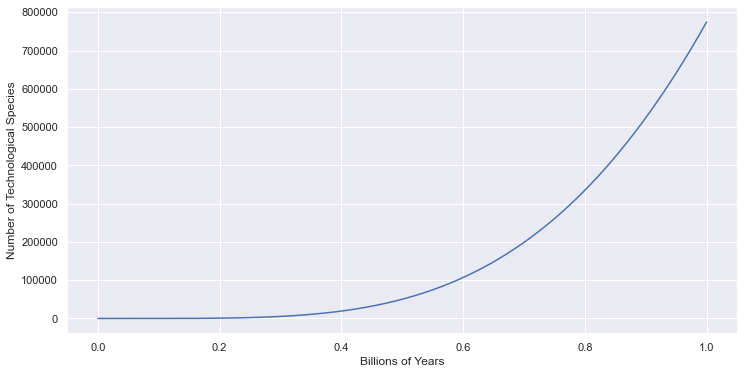

In [10]:
# plot of technological species over time

plt.figure(figsize=(12, 6))
plot = sns.lineplot(x=history_of_life.index/1_000_000_000, y=history_of_life.N);
plt.yticks(rotation=0);
plot.set_ylabel('Number of Technological Species');
plot.set_xlabel('Billions of Years');

# compare values of YEAR_STEPS 
    complex or higher are not working 
    num_life or higher are inconsistent with old odds calcs

In [42]:
%%time
params['YEAR_STEPS'] = 10_000_000
ts_10M = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

ts_10M.tail()

Wall time: 1.66 s


,n_star,n_planet,n_habitable,n_life,n_complex,n_int,n_cult,N,N_extinct
year,,,,,,,,,
9960000000,95_049_310_897,38_019_724_359,36_956_349_231,35_331_631_432,22_765_440_925,11_538_831_259,4_316_514_984,-707_253,-374_811_412
9970000000,95_050_301_035,38_020_120_414,36_961_666_107,35_340_437_238,22_773_246_725,11_542_969_200,4_318_069_449,-707_500,-375_518_666
9980000000,95_051_290_975,38_020_516_390,36_966_958_378,35_349_206_571,22_781_022_336,11_547_091_276,4_319_617_958,-707_745,-376_226_165
9990000000,95_052_280_717,38_020_912_287,36_972_226_168,35_357_939_557,22_788_767_852,11_551_197_536,4_321_160_531,-707_989,-376_933_910
10000000000,95_053_270_261,38_021_308_104,36_977_469_599,35_366_636_320,22_796_483_365,11_555_288_028,4_322_697_186,-708_233,-377_641_900


In [43]:
%%time
params['YEAR_STEPS'] = 100_000_000
ts_100M = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

ts_100M.tail()

Wall time: 180 ms


,n_star,n_planet,n_habitable,n_life,n_complex,n_int,n_cult,N,N_extinct
year,,,,,,,,,
9600000000,95_155_520_978,38_062_208_391,36_880_011_661,35_132_996_853,22_982_710_236,13_460_390_175,8_062_119_156,-16_869_224,-777_640_929
9700000000,95_165_209_936,38_066_083_974,36_939_121_498,35_232_431_096,23_074_012_901,13_517_594_401,8_097_860_038,-16_945_142,-794_510_153
9800000000,95_174_879_516,38_069_951_806,36_995_469_621,35_327_845_681,23_161_871_909,13_572_666_651,8_132_278_718,-17_018_530,-811_455_295
9900000000,95_184_529_757,38_073_811_903,37_049_193_731,35_419_367_985,23_246_391_793,13_625_671_287,8_165_414_699,-17_089_128,-828_473_825
10000000000,95_194_160_697,38_077_664_279,37_100_424_639,35_507_126_121,23_327_674_420,13_676_670_940,8_197_306_703,-17_157_021,-845_562_954


In [44]:
ts_100M.head(11)

,n_star,n_planet,n_habitable,n_life,n_complex,n_int,n_cult,N,N_extinct
year,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
100000000,5_940_000_000,2_376_000_000,0,0,0,0,0,0,0
200000000,11_470_728_000,4_588_291_200,118_800_000,0,0,0,0,0,0
300000000,16_623_131_630,6_649_252_652,342_274_560,11_305_315,0,0,0,0,0
400000000,21_425_639_248,8_570_255_699,657_623_465,42_678_128,1_062_899,0,0,0,0
500000000,25_904_377_811,10_361_751_125,1_053_255_076,100_837_441,4_929_318,393_918,0,0,0
600000000,30_083_370_903,12_033_348_361,1_518_679_879,190_767_514,13_730_131,1_973_038,234_292,0,0
700000000,33_984_718_806,13_593_887_523,2_044_413_303,315_987_515,29_768_277,5_820_876,1_177_163,-1_558,0
800000000,37_628_762_328,15_051_504_931,2_621_887_014,478_786_353,55_356_503,13_193_332,3_479_607,-6_928,-1_558


In [45]:
%%time
params['YEAR_STEPS'] = 1_000_000
ts_1M = TimeDependentDrake(params, output_year=10_000_000_000, P_tech_dominance=1)

ts_1M.tail()

Wall time: 15.9 s


,n_star,n_planet,n_habitable,n_life,n_complex,n_int,n_cult,N,N_extinct
year,,,,,,,,,
9996000000,95_039_003_081,38_015_601_233,36_963_131_775,35_349_216_742,22_739_909_023,11_328_440_917,691_604_021,100_099_924,510_056_010_622
9997000000,95_039_102_301,38_015_640_921,36_963_658_010,35_350_086_706,22_740_677_473,11_328_840_529,691_628_430,100_103_458,510_156_110_545
9998000000,95_039_201_519,38_015_680_608,36_964_184_001,35_350_956_308,22_741_445_626,11_329_239_987,691_652_830,100_106_991,510_256_214_004
9999000000,95_039_300_735,38_015_720_294,36_964_709_749,35_351_825_549,22_742_213_480,11_329_639_292,691_677_220,100_110_523,510_356_320_995
10000000000,95_039_399_949,38_015_759_980,36_965_235_255,35_352_694_429,22_742_981_037,11_330_038_443,691_701_602,100_114_053,510_456_431_518


In [46]:
ts_1M.iloc[::100, :].head(11)

,n_star,n_planet,n_habitable,n_life,n_complex,n_int,n_cult,N,N_extinct
year,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
100000000,5_796_686_127,2_318_674_451,57_118_743,1_818_863,42_953,3_559,204,28,448
200000000,11_204_063_326,4_481_625_330,220_721_250,13_984_873,658_197,97_620,5_786,818,27_850
300000000,16_250_786_932,6_500_314_773,478_299_361,44_923_674,3_128_417,621_993,37_262,5_311,281_878
400000000,20_963_244_203,8_385_297_681,818_491_830,101_131_872,9_240_405,2_204_986,132_786,19_008,1_385_618
500000000,25_365_744_833,10_146_297_933,1_230_986_007,187_464_823,21_050_660,5_696_180,344_091,49_380,4_616_016
600000000,29_480_694_629,11_792_277_851,1_706_427_854,307_388_051,40_708_510,12_078_497,731_115,105_093,12_062_736
700000000,33_328_753_902,13_331_501_561,2_236_339_607,463_196_546,70_325_579,22_388_650,1_357_138,195_305,26_711_756
800000000,36_928_981_987,14_771_592_795,2_813_044_394,656_205_682,111_882_345,37_653_550,2_284_884,329_099,52_465_148


### These do not work at all
    do not converge to steady state (blast past it)
    end up negative
    unrealistic number of early transitions
        should be a threshold to transition

# DO TRANSITION PERCENTAGES MAKE SENSE?
    (no)

In [51]:
def print_param_timing(parameter):
    current_param = parameter
    print(current_param)

    # transition(params, num_from, num_to, prob_of_transition)
    num_from, num_to = 1_000_000, 0
    prob_of_transition = params[current_param]

    # probability, avg yrs
    prob_transition = transition(params, num_from, num_to, prob_of_transition) / num_from 
    print(f"{prob_transition*100:_.4f}% chance of transition over 1M years")
    print(f"{prob_of_transition:_.0f} years per transition on average")

    # percent that transition over 1B years
    output = 0
    for i in range(1000):
        output += prob_transition * (1 - output)

    print(f"{output*100:_.0f}% chance of transition over 1B years")

In [53]:
print_param_timing('YEARS_PLANETS_TO_HABITABLE')

YEARS_PLANETS_TO_HABITABLE
0.0500% chance of transition over 1M years
2_000_000_000 years per transition on average
39% chance of transition over 1B years


In [54]:
print_param_timing('YEARS_HABITABLE_TO_LIFE')

YEARS_HABITABLE_TO_LIFE
0.1000% chance of transition over 1M years
1_000_000_000 years per transition on average
63% chance of transition over 1B years


In [55]:
print_param_timing('YEARS_LIFE_TO_COMPLEX_LIFE')

YEARS_LIFE_TO_COMPLEX_LIFE
0.1000% chance of transition over 1M years
1_000_000_000 years per transition on average
63% chance of transition over 1B years


In [56]:
print_param_timing('YEARS_COMPLEX_TO_INTELLIGENCE')

YEARS_COMPLEX_TO_INTELLIGENCE
0.4988% chance of transition over 1M years
200_000_000 years per transition on average
99% chance of transition over 1B years


In [57]:
print_param_timing('YEARS_INTELLIGENCE_TO_CULTURE')

YEARS_INTELLIGENCE_TO_CULTURE
4.8771% chance of transition over 1M years
20_000_000 years per transition on average
100% chance of transition over 1B years


In [58]:
print_param_timing('YEARS_CULTURE_TO_TECH')

YEARS_CULTURE_TO_TECH
99.3262% chance of transition over 1M years
200_000 years per transition on average
100% chance of transition over 1B years


In [60]:
num = 1_000_000

extinction_simple, extinction_complex, extinction_intelligent, extinction_cultural, extinction_technological = new_extinctions(
  params, num_stars=100_000_000_000, num_life=num, num_complex_life=num, num_intelligent_life=num, num_cultural_life=num, N=num)

print(extinction_simple/num, extinction_complex/num, extinction_intelligent/num, extinction_cultural/num, extinction_technological/num)

1.99999999998e-05 0.0005198750208305296 0.005007520807317488 0.6321405588285575 1.0


# QA UPDATES TO POISSON FUNCTION
### Year Steps

In [18]:
def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'], params['YEAR_STEPS'])

In [19]:
# reset
params['YEAR_STEPS'] = 1_000_000

In [20]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# 99% of cultuures evolve technology over 1M yr

0.9932620530009145

In [21]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing GOOD - this ratio is commutatitve

(0.9932620530009145, 0.3934693402873665)

In [22]:
def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * params['FC'] * prob_poisson(params['YEARS_CULTURE_TO_TECH'], params['YEAR_STEPS'])

In [23]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# % of cultuures evolve technology over 1M yr

0.09932620530009145

In [24]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing BAD, not commutative anymore, because of FC factor

(0.33063078988391387, 0.03934693402873665)

In [25]:
# reset
params['YEAR_STEPS'] = 1_000_000

In [26]:
# USE THIS ONE FOR NOW

def new_technological(params, num_cultural_life, N):
    """
    the number of planets with cultural life that develop technological life
    doesn't track planets, uses ratios to approximate expectations
    doesn't account for number of tech species, ie, doesn't use (num_cultural_life - num_tech_life)
    this is because of P_tech_dominance:
        some proportion of cultural species transition or otherwise become
        extinct as a result of sharing a planet with a technological species
        P_tech_dominance is not a CONSTANT, it is treated as an input to TimeDependentDrake()
    FC is the percentage of intelligent species that develop communication
    """
    
    return num_cultural_life * prob_poisson(params['YEARS_CULTURE_TO_TECH'] / params['FC'], params['YEAR_STEPS'])

In [27]:
# reset
params['YEAR_STEPS'] = 1_000_000

num_cult = 1_000_000
num_N = 0

new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult

# % of cultuures evolve technology over 1M yr

0.3934693402873665

In [28]:
params['YEAR_STEPS'] = 100_000
output = 0
conversion_ratio = new_technological(params, num_cultural_life=num_cult, N=num_N) / num_cult
for i in range(10):
    output += conversion_ratio * (1 - output)
output, conversion_ratio

# testing GOOD AGAIN, now commutative and uses FC

(0.3934693402873665, 0.048770575499285984)

In [29]:
# reset
params['YEAR_STEPS'] = 1_000_000

# what about the weibull function?

In [61]:
def prob_weibull(params, years):
    """
    IMPORTANT: this won't work with different timesteps without WEIBULL_SHAPE_PARAMETER=1
        need WEIBULL_SHAPE_PARAMETER=1 for prob_L(params, 1_000)**100 == prob_L(params, 100_000)
        maybe use this for monte carlo simulation, but can't rely on it for simple calcs
            otherwise time_step becomes an integral part of the calculation
    weibull distribution
    constants from the CONSTANTS section above but shape=1
    """
    
    k = params['WEIBULL_SHAPE_PARAMETER']
    l = params['WEIBULL_SCALE_PARAMETER']
    
    return 1 - exp(-(years / l) ** k)

In [64]:
print(f"k = {params['WEIBULL_SHAPE_PARAMETER']}")
print(f"lambda = {params['WEIBULL_SCALE_PARAMETER']}")

k = 0.4
lambda = 20000


In [63]:
prob_weibull(params, 20000)

0.6321205588285577

In [65]:
output = 0
for i in range(10):
    output += prob_weibull(params, 2000) * (1 - output)
output

0.9813343754384811

In [66]:
params['WEIBULL_SHAPE_PARAMETER'] = 1  # default = 0.4
print(f"k = {params['WEIBULL_SHAPE_PARAMETER']}")
print(f"lambda = {params['WEIBULL_SCALE_PARAMETER']}")

k = 1
lambda = 20000


In [67]:
prob_weibull(params, 20000)

0.6321205588285577

In [68]:
output = 0
for i in range(10):
    output += prob_weibull(params, 2000) * (1 - output)
output

0.6321205588285579

# weibull with scale = 1.0 is commutative

In [69]:
# compare with poisson

mu, years = 20000, 20000

prob_weibull(params, years), prob_poisson(mu, years)

(0.6321205588285577, 0.6321205588285577)

In [79]:
current_param = params['YEARS_PLANETS_TO_HABITABLE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

2_000_000_000
0.000499875020830709		0.0004998750208307296		0.9999999999999588


In [85]:
current_param = params['YEARS_HABITABLE_TO_LIFE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

1_000_000_000
0.000999500166624978		0.0009995001666250082		0.9999999999999698


In [81]:
current_param = params['YEARS_LIFE_TO_COMPLEX_LIFE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

1_000_000_000
0.000999500166624978		0.0009995001666250082		0.9999999999999698


In [82]:
current_param = params['YEARS_COMPLEX_TO_INTELLIGENCE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

200_000_000
0.00498752080731768		0.004987520807317688		0.9999999999999984


In [83]:
current_param = params['YEARS_INTELLIGENCE_TO_CULTURE']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

20_000_000
0.048770575499285984		0.04877057549928599		0.9999999999999999


In [84]:
current_param = params['YEARS_CULTURE_TO_TECH']
print(f"{current_param:_.0f}")

params['WEIBULL_SCALE_PARAMETER'] = current_param  # default = 20000
mu, years = current_param, 1_000_000  # 1_000_000 is default for TIME_STEPS

print(prob_weibull(params, years), prob_poisson(mu, years), prob_weibull(params, years)/prob_poisson(mu, years), sep='\t\t')

200_000
0.9932620530009145		0.9932620530009145		1.0


# weibull and poisson are EXACTLY the same (in this case)